In [ ]:
import pandas as pd
import numpy as np
import os,json,math

In [ ]:
resource_table_df = pd.read_csv(f"dls_resource_data_for_t20s.csv")

In [ ]:
def DLS_par_score_2(
    balls_available_to_team_one_at_start,
    runs_scored_by_team_one,
    balls_available_to_team_two_at_start,
    balls_remaining_to_team_two,
    wickets_lost_by_team_two
):
    resource_for_0_wickets_lost = resource_table_df["0"][::-1]

    total_resource_available_to_team_one_at_start = np.interp(
        balls_available_to_team_one_at_start, resource_table_df["balls"][::-1], resource_for_0_wickets_lost
    )
    total_resource_available_to_team_two_at_start = np.interp(
        balls_available_to_team_two_at_start, resource_table_df["balls"][::-1], resource_for_0_wickets_lost
    )

    team_two_remaining_resource = np.interp(
        balls_remaining_to_team_two,
        resource_table_df["balls"][::-1],
        resource_table_df[f"{wickets_lost_by_team_two}"][::-1]
    )

    team_two_available_resource = total_resource_available_to_team_two_at_start - team_two_remaining_resource

    par_score = runs_scored_by_team_one * (team_two_available_resource/total_resource_available_to_team_one_at_start)

    return par_score

In [ ]:
# Tie = 92 games

In [ ]:
def DLS_label(dls_score, current_score, true_label, alpha):
    if(dls_score == 0.0):
        chi_DLS = 1
    else:
        chi_DLS = min((current_score / dls_score), 1)
    new_label_win = (alpha * true_label) + ((1 - alpha) * chi_DLS)
    return new_label_win

In [ ]:
def chi_DLS_calc(dls_score, current_score, cutoff_score_for_DLS):
    chi_DLS = 0
    # Current score more than DLS score ==> win prob maximum(1)
    if(dls_score <= current_score):
        chi_DLS = 1
    else:
        # Current score difference with DLS score more than cut off ==> win prob minimum(0)
        if((dls_score - current_score) >= cutoff_score_for_DLS):
            chi_DLS = 0
        else:
            # Find chi_DLS in form of logarithmic decay ==> log(3-(diff)/(cuttoff/2))/log(3)
            chi_DLS = math.log(3 - ((dls_score - current_score) / (cutoff_score_for_DLS / 2))) / math.log(3)
    return chi_DLS

In [ ]:
def DLS_label_2(dls_score, current_score, true_label, count_balls_rem, make_alpha_one_at_rem_balls, cutoff_score_for_DLS):
    if(dls_score == 0.0):
        chi_DLS = 1
    else:
        chi_DLS = chi_DLS_calc(dls_score, current_score, cutoff_score_for_DLS)
    # Alpha linear decay => focus more on DLS at beginning and more on true_label towards the end
    alpha = min((120 - count_balls_rem) / (120 - make_alpha_one_at_rem_balls), 1)
    new_label_win = (alpha * true_label) + ((1 - alpha) * chi_DLS)
    return new_label_win

In [ ]:
# For second innings in each match
path_json = '/content/t20s_json/'
# cols = ['match_file', 'true_label', 'max_balls']
# cols.extend((np.arange(120)+1) .tolist())
# cols = [str(x) for x in cols]
# labels = pd.DataFrame(columns = cols)

alpha = 0.75

# Cutoff score 40 taken
cutoff_score_for_DLS = 40
# alpha become 1 in last 4 overs = 4*6 = 24
make_alpha_one_at_rem_balls = 24

label_file = open("/content/new_label_var_alpha_40_24.csv", 'w')

for file in os.listdir(path_json):
    if(file == "README.txt"):
        continue
    with open(path_json + file, 'r') as json_file:
        json_data = json.load(json_file)
        if("winner" in list(json_data["info"]["outcome"].keys())):
            row = []
            winner = json_data["info"]["outcome"]["winner"]
            true_label = int(winner == json_data["innings"][1]["team"])
            row.append(file)
            row.append(str(true_label))
            count_balls_rem = 120
            target_score = 1
            wicket_count = 0
            current_score = 0

            if("penalty_runs" in list(json_data["innings"][0].keys())):
                for key in list(json_data["innings"][0]["penalty_runs"].keys()):
                    target_score = target_score + json_data["innings"][0]["penalty_runs"][key]

            for over in json_data["innings"][0]["overs"]:
                for ball in over["deliveries"]:
                    target_score = target_score + ball["runs"]["total"]

            if("penalty_runs" in list(json_data["innings"][1].keys())):
                for key in list(json_data["innings"][1]["penalty_runs"].keys()):
                    current_score = current_score + json_data["innings"][1]["penalty_runs"][key]

            for over in json_data["innings"][1]["overs"]:
                for ball in over["deliveries"]:
                    if("extras" not in list(ball.keys())):
                        count_balls_rem = count_balls_rem - 1
                    elif("noballs" not in list(ball["extras"].keys()) and "wides" not in list(ball["extras"].keys())):
                        count_balls_rem = count_balls_rem - 1
                    if("wickets" in list(ball.keys())):
                        wicket_count = wicket_count + 1

                    new_label_win = true_label
                    current_score = current_score + ball["runs"]["total"]

                    if(wicket_count < 10):
                        dls_score = DLS_par_score_2(120, target_score, 120, count_balls_rem, wicket_count)
                        dls_score = math.ceil(dls_score)
                        new_label_win = DLS_label_2(dls_score, current_score, true_label, count_balls_rem, make_alpha_one_at_rem_balls, cutoff_score_for_DLS)

                    row.append(str(new_label_win))

            line = ','.join(row)
            line = line + '\n'
            label_file.write(line)

label_file.close()

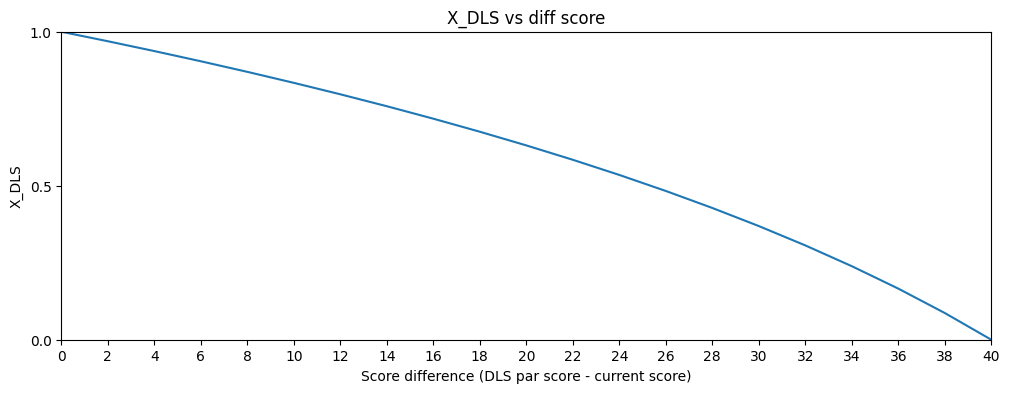

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image
import math

x_coordinates = list(range(0, 41,2))

# List of y-coordinates
y_coordinates = [math.log(3 - ((x_coordinates[i]) / (20))) / math.log(3) for i in range(len(x_coordinates))]

plt.figure(figsize=(12, 4))
# Plot the line graph
plt.plot(x_coordinates, y_coordinates, linestyle='-')

# Add labels and title
plt.xlabel('Score difference (DLS par score - current score)')
plt.ylabel('X_DLS')
plt.title('X_DLS vs diff score')
# plt.grid(visible=True)
plt.xticks(x_coordinates)
plt.yticks([0,0.5,1])
plt.xlim(0,40)
plt.ylim(0,1)

# Save the plot as an image file
plt.savefig('/content/DLS_graph.png', bbox_inches='tight')


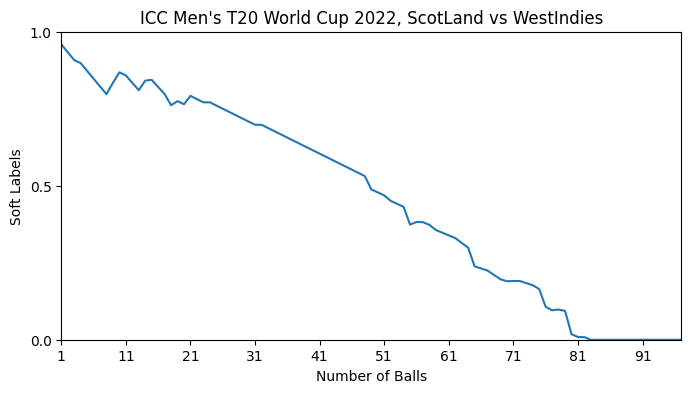

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image
import math

y_coordinates = [0.9590462540939729,0.9334501890650013,0.9079124825769851,0.8981499827643293,0.872840559027201,0.8475906803537019,0.8223993203980505,0.7972653321919599,0.8344739410479834,0.8681892405482282,0.8580940168209231,0.8341469774623417,0.8102874844504276,0.841099199302015,0.84375,0.8205845846848928,0.7975226744570932,0.7614749853871488,0.7745650505007458,0.7646347293404798,0.7916666666666666,0.78125,0.7708333333333334,0.7708333333333334,0.7604166666666666,0.75,0.7395833333333333,0.7291666666666667,0.71875,0.7083333333333333,0.6979166666666667,0.6979166666666667,0.6875,0.6770833333333333,0.6666666666666667,0.65625,0.6458333333333333,0.6354166666666667,0.625,0.6145833333333333,0.6041666666666667,0.59375,0.5833333333333333,0.5729166666666667,0.5625,0.5520833333333333,0.5416666666666667,0.53125,0.48812499063278764,0.478362490820132,0.4685999910074762,0.4508077612558072,0.4412161067610027,0.43162445226619833,0.3738416322950845,0.382270059942132,0.38165585935389706,0.3727801416945042,0.3562061922188048,0.347518236311029,0.3388302804032533,0.3301423244954776,0.3143668271572301,0.2988322449093703,0.23822091495384337,0.23141460309801923,0.22460829124219517,0.2103099178571525,0.19629603374969234,0.18996390362873455,0.19059336305804445,0.19057673196307465,0.1837704201072506,0.1769641082514265,0.16430462332590035,0.1069539349991113,0.09557382370949974,0.09804110708251867,0.09358469312422238,0.018073971740573656,0.008789621924073173,0.008327010243858797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
x_coordinates = list(range(1, len(y_coordinates)+1))

plt.figure(figsize=(8, 4))
# Plot the line graph
plt.plot(x_coordinates, y_coordinates, linestyle='-')

# Add labels and title
plt.xlabel('Number of Balls')
plt.ylabel('Soft Labels')
plt.title('ICC Men\'s T20 World Cup 2022, ScotLand vs WestIndies')
# plt.grid(visible=True)
plt.xticks(list(range(1, len(y_coordinates)+1, 10)))
plt.yticks([0,0.5,1])
plt.xlim(1,len(x_coordinates))
plt.ylim(0,1)

# Save the plot as an image file
plt.savefig('/content/label_graph.png', bbox_inches='tight')
